## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Define Dataset

In [2]:
df = pd.read_csv("heart.csv")
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


## Exploratory Analysis

### Understand Dataset

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


## Dataset Overview

- **Number of Features:** 12
- **Feature Types:**
  - 5 categorical features
  - 6 numerical features
- **Target Type:**
  - Numerical feature
- **Missing Values:** None


**RestingBP** represents the resting blood pressure (mmHg).  
**Cholesterol** represents the serum cholesterol level (mg/dL).  
**FastingBS** indicates if fasting blood sugar is greater than 120 mg/dL.  
**RestingECG** results of the resting electrocardiogram test.  
**MaxHR** represents the maximum heart rate achieved.  
**ExerciseAngina** indicates if exercise-induced angina is present.  
**Oldpeak** represents the ST depression induced by exercise relative to rest (often used to measure ischemia).  
**ST_Slope** represents the slope of the peak exercise ST segment.  
**HeartDisease** is the target column

### Descriptive Analysis

#### Numerical features

In [5]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


**Validate features Range**

- **Age**: 0 to 120 years  
  **Validated**

- **RestingBP (Resting Blood Pressure)**: 0 to 250 mmHg  
  - Typical systolic blood pressure values.  
  - *Values below 90 or above 200 are clinically abnormal.* 
  **Validated**

- **Cholesterol**: 0 to 600 mg/dL  
  - Normal and extreme clinical levels.  
  - *Values above 300 are rare and usually indicate a serious condition.*  
  **Max observed: 603**

- **FastingBS (Fasting Blood Sugar)**: [0, 1]  
  - Binary indicator:  
    - `1` for fasting blood sugar > 120 mg/dL  
    - `0` otherwise.  
  **Validated**

- **MaxHR (Maximum Heart Rate)**: 0 to 220 bpm  
  - Calculated roughly as 220 minus age, though extremes are possible.  
  - *Typical values range from 60 bpm (resting) to around 200 bpm (during exercise).* 
  
    **Validated**

- **Oldpeak**: 0 to 10.0  
  - Represents ST depression or elevation, typically measured in mm.  
  - *Values above 5.0 are rare and clinically significant.*  
  **Negative values observed.**

- **HeartDisease**: [0, 1]  
  - Binary indicator:  
    - `1` for presence of heart disease  
    - `0` for absence.


Values Outside the Expected Range:

- **Cholesterol**: Expected range from 0 to 600 mg/dL, but **603 mg/dL** was observed.
- **Oldpeak**: Expected range from 0 to 10.0, but **negative values** were observed.


##### data correction

###### **Cholestrol**

In [6]:
df['Cholesterol'] [ df['Cholesterol'] > 600].count()

np.int64(1)

Only one value is outside the expected range, it will be dealt with it during outliers detection

###### **Oldpeak**

In [7]:
df['Oldpeak'] [ df['Oldpeak'] < 0].count()

np.int64(13)

Since *Oldpeak* cannot be negative, the negative values are considered entry errors and will be converted to positive values.

In [8]:
df['Oldpeak'] = df['Oldpeak'].abs()

#### Categorical features

In [9]:
for col in df.select_dtypes(include='object').columns:
    print(col)
    print(df[col].unique())
    print()

Sex
['M' 'F']

ChestPainType
['ATA' 'NAP' 'ASY' 'TA']

RestingECG
['Normal' 'ST' 'LVH']

ExerciseAngina
['N' 'Y']

ST_Slope
['Up' 'Flat' 'Down']



**ChestPainType**:
ATA (Atypical Angina),
NAP (Non-Anginal Pain),
ASY (Asymptomatic),
TA (Typical Angina)

**RestingECG**:
Normal,
ST (ST-segment depression or elevation),
LVH (Left Ventricular Hypertrophy)

##### categories frequency

In [10]:
for col in df.select_dtypes(include='object').columns:
    print(df[col].value_counts())
    print()

Sex
M    725
F    193
Name: count, dtype: int64

ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64

RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64

ExerciseAngina
N    547
Y    371
Name: count, dtype: int64

ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64



##### inspecting infrequent categories

In [11]:
def detect_infrequent_categories(df, feature, threshold = 0.05*len(df)):
    value_counts = df[feature].value_counts()
    infrequent = value_counts[value_counts < threshold].index
    return infrequent

In [12]:
outliers = {}
for feature in df.select_dtypes(include=['object']):
    olist = detect_infrequent_categories(df, feature)
    outliers[feature] = olist


outliers

{'Sex': Index([], dtype='object', name='Sex'),
 'ChestPainType': Index([], dtype='object', name='ChestPainType'),
 'RestingECG': Index([], dtype='object', name='RestingECG'),
 'ExerciseAngina': Index([], dtype='object', name='ExerciseAngina'),
 'ST_Slope': Index([], dtype='object', name='ST_Slope')}

No outliers in categorical columns 

### Drop duplicates

In [13]:
df.duplicated().sum()

np.int64(0)

We don't have duplicates

## Preprocessing

In [14]:
data = df.drop('HeartDisease', axis=1)

In [ ]:
categorical_features = list(data.select_dtypes(include=['object']).columns)
numerical_features = list(data.select_dtypes(include=['number']).columns)



['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

### Label Encoding

In [16]:
data[categorical_features]

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up
...,...,...,...,...,...
913,M,TA,Normal,N,Flat
914,M,ASY,Normal,N,Flat
915,M,ASY,Normal,Y,Flat
916,F,ATA,LVH,N,Flat


In [17]:
label_encoder = LabelEncoder()
for feature in categorical_features:
    data[feature] = label_encoder.fit_transform(data[feature])

In [18]:
data[categorical_features]

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,1,1,1,0,2
1,0,2,1,0,1
2,1,1,2,0,2
3,0,0,1,1,1
4,1,2,1,0,2
...,...,...,...,...,...
913,1,3,1,0,1
914,1,0,1,0,1
915,1,0,1,1,1
916,0,1,0,0,1


### Standardization

In [19]:
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,1,1,140,289,0,1,172,0,0.0,2
1,49,0,2,160,180,0,1,156,0,1.0,1
2,37,1,1,130,283,0,2,98,0,0.0,2
3,48,0,0,138,214,0,1,108,1,1.5,1
4,54,1,2,150,195,0,1,122,0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1
914,68,1,0,144,193,1,1,141,0,3.4,1
915,57,1,0,130,131,0,1,115,1,1.2,1
916,57,0,1,130,236,0,0,174,0,0.0,1


In [20]:
data[data.columns] = StandardScaler().fit_transform(data)
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,-1.433140,0.515952,0.229032,0.410909,0.825070,-0.551341,0.017255,1.382928,-0.823556,-0.878238,1.052114
1,-0.478484,-1.938163,1.275059,1.491752,-0.171961,-0.551341,0.017255,0.754157,-0.823556,0.081322,-0.596078
2,-1.751359,0.515952,0.229032,-0.129513,0.770188,-0.551341,1.601219,-1.525138,-0.823556,-0.878238,1.052114
3,-0.584556,-1.938163,-0.816995,0.302825,0.139040,-0.551341,0.017255,-1.132156,1.214246,0.561102,-0.596078
4,0.051881,0.515952,1.275059,0.951331,-0.034755,-0.551341,0.017255,-0.581981,-0.823556,-0.878238,1.052114
...,...,...,...,...,...,...,...,...,...,...,...
913,-0.902775,0.515952,2.321086,-1.210356,0.596393,-0.551341,0.017255,-0.188999,-0.823556,0.273234,-0.596078
914,1.536902,0.515952,-0.816995,0.627078,-0.053049,1.813758,0.017255,0.164684,-0.823556,2.384267,-0.596078
915,0.370100,0.515952,-0.816995,-0.129513,-0.620168,-0.551341,0.017255,-0.857069,1.214246,0.273234,-0.596078
916,0.370100,-1.938163,0.229032,-0.129513,0.340275,-0.551341,-1.566710,1.461525,-0.823556,-0.878238,-0.596078


### Dimensionality Reduction (PCA)

In [21]:
pca = PCA(2).fit_transform(data)
pca

array([[ 2.28522673,  0.12470253],
       [ 1.14869747,  1.0758018 ],
       [ 1.12329994, -1.20393642],
       ...,
       [-1.65078575, -0.07483389],
       [ 1.73056537,  1.46702607],
       [ 2.50816008, -0.54018307]])

#### PCA projection scatter plot

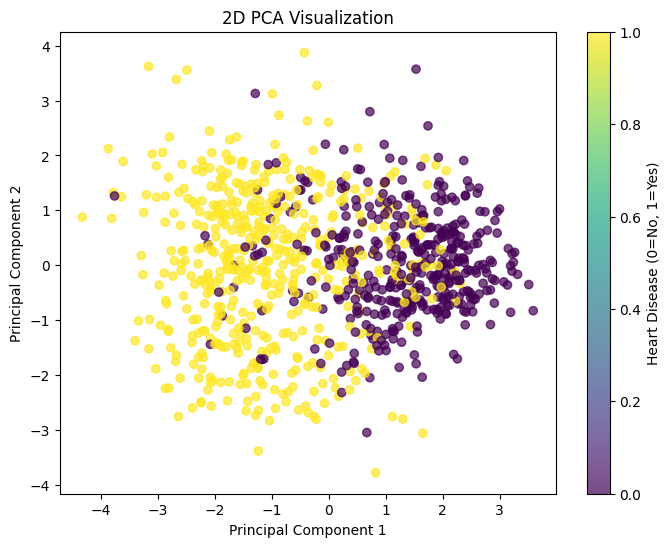

In [22]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca[:, 0], pca[:, 1], c=df['HeartDisease'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Heart Disease (0=No, 1=Yes)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Visualization')
plt.show()

### Handle Outliers

In [23]:
def detect_outliers(df, feature, threshold=3):
    z_scores = zscore(df[feature])
    outliers = (z_scores > abs(threshold))
    print(f"{outliers.sum()} outliers detected in '{feature}':")
    print(df[feature][outliers])
    print("-" * 50)
    return df[feature][outliers]

In [49]:
for feature in numerical_features:
    detect_outliers(data, feature)

0 outliers detected in 'Age':
Series([], Name: Age, dtype: float64)
--------------------------------------------------
7 outliers detected in 'RestingBP':
109    3.113018
241    3.653439
365    3.653439
399    3.653439
592    3.113018
732    3.653439
759    3.221102
Name: RestingBP, dtype: float64
--------------------------------------------------
3 outliers detected in 'Cholesterol':
76     3.020369
149    3.697252
616    3.340516
Name: Cholesterol, dtype: float64
--------------------------------------------------
0 outliers detected in 'FastingBS':
Series([], Name: FastingBS, dtype: float64)
--------------------------------------------------
0 outliers detected in 'MaxHR':
Series([], Name: MaxHR, dtype: float64)
--------------------------------------------------
6 outliers detected in 'Oldpeak':
166    3.919564
702    3.151916
771    4.495300
791    3.151916
850    5.071037
900    3.343828
Name: Oldpeak, dtype: float64
--------------------------------------------------


Since the outliers are meaningful and provide important insights (rare but valid in medical datasets),
they will be retained in the dataset.

## Training Classifiers

#### Convert target to categorical

In [25]:
df['HeartDisease'] = df['HeartDisease'].map({0: 'No', 1: 'Yes'})
df['HeartDisease']

0       No
1      Yes
2       No
3      Yes
4       No
      ... 
913    Yes
914    Yes
915    Yes
916    Yes
917     No
Name: HeartDisease, Length: 918, dtype: object

#### Split data into Train, Validation, and Test Sets

In [26]:
X = data
y = df["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

Split data into training (80%), testing (20%)

Then training into training (80%), validation (20%)

64% training - 16% validation - 20% testing

#### Evaluation functions

In [27]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    results = classification_report(y_true, y_pred)
    print(results)
    print("Accuracy:", accuracy_score(y_true, y_pred))

In [28]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

### SVM Classifier

### Training

#### Hyperparameter tuning for SVM

In [29]:
# Grids hyperparameter
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 0.01, 0.001]
}

In [30]:
# Set up GridSearchCV for SVM
svm_model = SVC(random_state=42)
svm_grid_search = GridSearchCV(estimator=svm_model, param_grid=svm_param_grid, scoring='f1_weighted', cv=5)

#### Fit model to get best hyperparameters

In [31]:
svm_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf']},
             scoring='f1_weighted')

#### Get best parameters

In [32]:
print("Best parameters for SVM:", svm_grid_search.best_params_)
best_svm_model = svm_grid_search.best_estimator_
y_val_pred_svm = best_svm_model.predict(X_val)

Best parameters for SVM: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


### Training Evaluation

#### Classification Report

In [33]:
evaluate_model(y_val, y_val_pred_svm, "Tuned SVM")


Tuned SVM Performance:
              precision    recall  f1-score   support

          No       0.86      0.83      0.85        66
         Yes       0.87      0.89      0.88        81

    accuracy                           0.86       147
   macro avg       0.86      0.86      0.86       147
weighted avg       0.86      0.86      0.86       147

Accuracy: 0.8639455782312925


#### Confusion Matrix

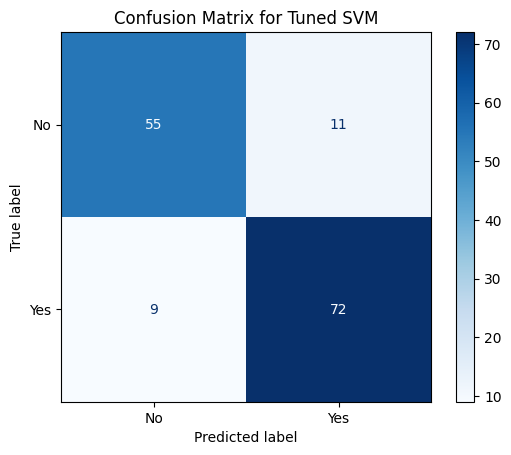

In [34]:
plot_confusion_matrix(y_val, y_val_pred_svm, "Tuned SVM")

### Testing Evaluation

In [35]:
y_test_pred_svm = best_svm_model.predict(X_test)
evaluate_model(y_test, y_test_pred_svm, "Tuned SVM")


Tuned SVM Performance:
              precision    recall  f1-score   support

          No       0.89      0.89      0.89        74
         Yes       0.93      0.93      0.93       110

    accuracy                           0.91       184
   macro avg       0.91      0.91      0.91       184
weighted avg       0.91      0.91      0.91       184

Accuracy: 0.9130434782608695


## Bayes Classifiers

### Training

#### Hyper Parameter tuning for Bayes

In [36]:
# Define hyperparameter grids for Naive Bayes
nb_param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

In [37]:
# Set up GridSearchCV for Naïve Bayes
nb_model = GaussianNB()
nb_grid_search = GridSearchCV(estimator=nb_model, param_grid=nb_param_grid, scoring='f1_weighted', cv=5)

#### Fit model to get best hyperparameters

In [38]:
nb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]},
             scoring='f1_weighted')

#### Get best parameters¶

In [39]:
print("Best parameters for Naïve Bayes:", nb_grid_search.best_params_)
best_nb_model = nb_grid_search.best_estimator_
y_val_pred_nb = best_nb_model.predict(X_val)

Best parameters for Naïve Bayes: {'var_smoothing': 1e-09}


### Training Evaluation

#### Classification Report

In [40]:
evaluate_model(y_val, y_val_pred_nb, "Tuned Naïve Bayes")


Tuned Naïve Bayes Performance:
              precision    recall  f1-score   support

          No       0.83      0.88      0.85        66
         Yes       0.90      0.85      0.87        81

    accuracy                           0.86       147
   macro avg       0.86      0.87      0.86       147
weighted avg       0.87      0.86      0.86       147

Accuracy: 0.8639455782312925


#### Confusion Matrix

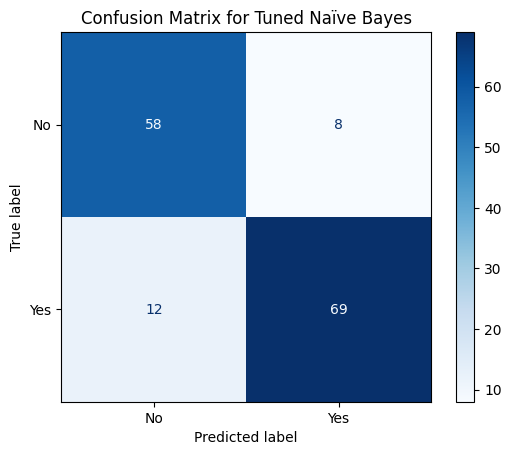

In [41]:
plot_confusion_matrix(y_val, y_val_pred_nb, "Tuned Naïve Bayes")

### Testing Evaluation

In [42]:
y_test_pred_nb = best_nb_model.predict(X_test)
report_test_nb = evaluate_model(y_test, y_test_pred_nb, "Tuned Naïve Bayes")


Tuned Naïve Bayes Performance:
              precision    recall  f1-score   support

          No       0.86      0.88      0.87        74
         Yes       0.92      0.90      0.91       110

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184

Accuracy: 0.8913043478260869


## SVM vs Naïve Bayes: Validation & Testing Metrics

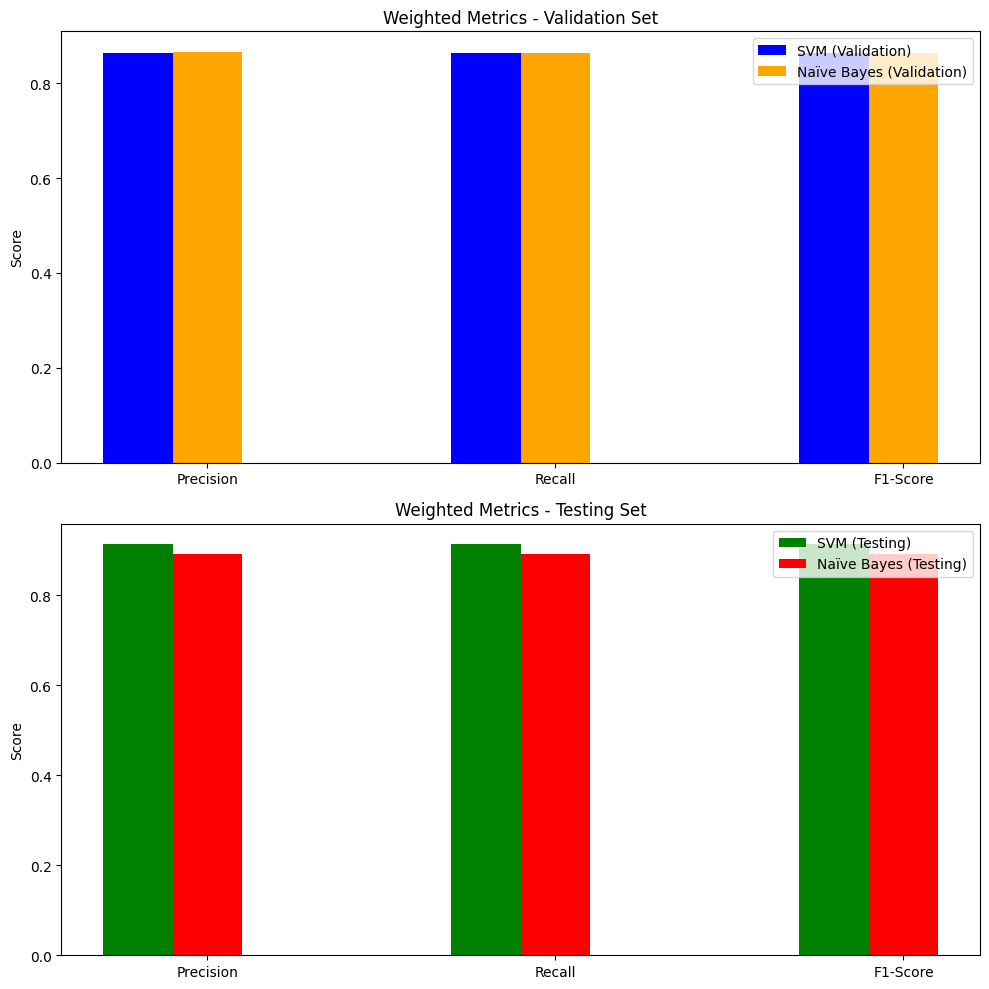

In [43]:
# Generate classification reports as dictionaries for validation
report_val_svm = classification_report(y_val, y_val_pred_svm, output_dict=True)
report_val_nb = classification_report(y_val, y_val_pred_nb, output_dict=True)

# Generate classification reports as dictionaries for testing
report_test_svm = classification_report(y_test, y_test_pred_svm, output_dict=True)
report_test_nb = classification_report(y_test, y_test_pred_nb, output_dict=True)

# Extract weighted average metrics
metrics = ["precision", "recall", "f1-score"]

# Validation metrics
svm_val_metrics = [report_val_svm["weighted avg"][metric] for metric in metrics]
nb_val_metrics = [report_val_nb["weighted avg"][metric] for metric in metrics]

# Testing metrics
svm_test_metrics = [report_test_svm["weighted avg"][metric] for metric in metrics]
nb_test_metrics = [report_test_nb["weighted avg"][metric] for metric in metrics]

# Labels for the histogram
x_labels = ["Precision", "Recall", "F1-Score"]

# Plotting the histograms
x = np.arange(len(metrics))  # The label locations
width = 0.2  # Width of the bars

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Validation dataset
ax[0].bar(x - width, svm_val_metrics, width, label="SVM (Validation)", color='blue')
ax[0].bar(x, nb_val_metrics, width, label="Naïve Bayes (Validation)", color='orange')

ax[0].set_ylabel("Score")
ax[0].set_title("Weighted Metrics - Validation Set")
ax[0].set_xticks(x)
ax[0].set_xticklabels(x_labels)
ax[0].legend(loc="best")

# Testing dataset
ax[1].bar(x - width, svm_test_metrics, width, label="SVM (Testing)", color='green')
ax[1].bar(x, nb_test_metrics, width, label="Naïve Bayes (Testing)", color='red')

ax[1].set_ylabel("Score")
ax[1].set_title("Weighted Metrics - Testing Set")
ax[1].set_xticks(x)
ax[1].set_xticklabels(x_labels)
ax[1].legend(loc="best")

plt.tight_layout()
plt.show()

### EXTRA

In [44]:
# Train Naïve Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_val_pred_nb = nb_model.predict(X_val)

In [45]:
# Train SVM
svm_model = SVC(kernel="linear", C=1, random_state=42)
svm_model.fit(X_train, y_train)
y_val_pred_svm = svm_model.predict(X_val)

In [46]:
# Evaluate on Validation Set
evaluate_model(y_val, y_val_pred_nb, "Naïve Bayes")
evaluate_model(y_val, y_val_pred_svm, "SVM")

# Final Evaluation on Test Set
print("\nFinal Test Performance (Naïve Bayes):")
y_test_pred_nb = nb_model.predict(X_test)
evaluate_model(y_test, y_test_pred_nb, "Naïve Bayes")

print("\nFinal Test Performance (SVM):")
y_test_pred_svm = svm_model.predict(X_test)
evaluate_model(y_test, y_test_pred_svm, "SVM")


Naïve Bayes Performance:
              precision    recall  f1-score   support

          No       0.83      0.88      0.85        66
         Yes       0.90      0.85      0.87        81

    accuracy                           0.86       147
   macro avg       0.86      0.87      0.86       147
weighted avg       0.87      0.86      0.86       147

Accuracy: 0.8639455782312925

SVM Performance:
              precision    recall  f1-score   support

          No       0.83      0.88      0.85        66
         Yes       0.90      0.85      0.87        81

    accuracy                           0.86       147
   macro avg       0.86      0.87      0.86       147
weighted avg       0.87      0.86      0.86       147

Accuracy: 0.8639455782312925

Final Test Performance (Naïve Bayes):

Naïve Bayes Performance:
              precision    recall  f1-score   support

          No       0.86      0.88      0.87        74
         Yes       0.92      0.90      0.91       110

    accuracy   